<a href="https://colab.research.google.com/github/mfdali/PermeabilityCircularVugs/blob/main/MVP_Sprint2_DeepL_Monique_Dali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Modelo de Regressão - Permabilidade equivalente

**MVP 2**

### @author: Monique Dali

### Data Science & Analytics

## 1. Definição do Problema

A base de dados consiste em imagens binárias e soluções de simulações numéricas do escoamento de fluidos em lâminas bidimensionais de duas amostras de rocha. O simulador foi implementado por Dali, Gomes e Carvalho no Laboratório de Microhidrodinâmica e Escoamento em Meios Porosos da PUC-Rio, com os objetivos de encontrar uma solução aproximada para a pressão e velocidade ao longo de um domínio com vazios e matriz porosa e calcular sua permeabilidade absoluta. Esta base é composta por imagens tomográficas de 2 amostras de carbonato com cavidades, o qual não possui solução teórica para o escoamento. Com base nessas imagens, outras foram manipuladas virtualmente para obter macroporosidades maiores. Das imagens alguns atributos foram extraídos. O dataset apresenta esses atributos obtidos da imagem, parâmetros de construção do estudo e a permeabilidade absoluta encontrada pela simulação.
Para mais detalhes sobre o estudo que gerou este dataset, o artigo encontra-se disponível em: https://www.researchgate.net/publication/337746813_Equivalent_permeability_in_vuggy_porous_media_using_Brinkman's_model

**Target:**

- **Knorm** - Permeabilidade equivalente dividido pela permeabilidade da matriz porosa. Representa o incremento de permabilidade devido a presença das cavidades.



**Exemplo de imagem pertencente a base de dados**

- região branca - meio poroso

- áreas em preto - cavidades

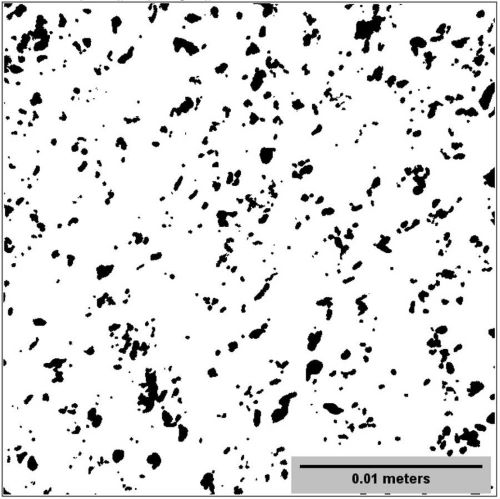

## 2. Importando as bibliotecas necessárias para executar o notebook

Instalação de bibliotecas necessárias

In [1]:
# Libraries download
! pip install tensorflow
! pip install keras

In [2]:
!pip install gdown

In [124]:
# Import libraries

import os
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from IPython.display import display
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tempfile
import gdown
import zipfile
import time

## 3. Ferramentas: Classes e funções

In [72]:
# Classes and functions

class LoadData:

    def load_data(self, directory, csv_path):
        # Download the file list from the Google Drive link
        self._download_file_list(directory)

        self._load_images()

        image_filenames, targets = self._read_file_list(csv_path)
        return image_filenames, targets


    def _download_file_list(self, file_id):
        # Construct the URL to download the file list
        url = f"https://drive.google.com/uc?id={file_id}"
        response = requests.get(url)
        folder_path = "./dataset"  # Folder name to download file
        os.makedirs(folder_path, exist_ok=True) # Create folder destination if necessary
        # download zip file
        output = "dataset/train.zip"  # filename and extension
        gdown.download(url, output)
        time.sleep(5)

    def _read_file_list(self, csv_path):
        # Read targets from csv file
        df = pd.read_csv(csv_path)
        df2 = df

        # Create a new column with image file extension
        df2.insert(0,"file_name",df2["Image_file"].values+".tif")

        # Drop rows with NaN
        #df2 = df2[df2.Knorm.notnull()]

        # Filter dataframe by Column value
        #df2 = df2[(df2["Sample"] == 5) & (df2["Threshold"]<2) & (df2["Direction"]=="X")].reset_index(drop=True)
        df2 = df2[(df2["Threshold"]<3) & (df2["Knorm"]>=1) & (df2["Direction"]=="X") & (df2["file_name"]!='am8_c2_final-1459.tif')].reset_index(drop=True)

        # Get image list to be processed
        image_filenames = df2.iloc[:, 0].tolist()
        targets = df2.iloc[:, -2].tolist()

        return image_filenames, targets

    def _load_images(self):
        # Extract compressed images to folder
        output = "dataset/train.zip"
        destination = 'dataset/images/' # path to zip file 'train.zip'

        os.makedirs(destination,exist_ok=True) # Create folder destination if necessary

        with zipfile.ZipFile(output,'r') as zip_ref:
            zip_ref.extractall(destination)

class RegressorModel:
    # Binary image regressor that uses GoogLeNet

    def __init__(self, input_shape, dataframe, batch_size, epochs):
        self.input_shape = input_shape
        self.model = None
        self.history = None
        self.train_df = None
        self.test_df = None
        self.val_df = None
        self.batch_size = batch_size
        self.epochs = epochs

    def load_dataset(self, dataframe, test_size=0.25, random_state=42):
        # Split the dataset into training and validation sets
        self.train_df, subtest_df = train_test_split(dataframe, test_size=test_size, random_state=random_state)
        self.test_df, self.val_df = train_test_split(subtest_df, test_size=0.2, random_state=random_state)
        train_df = self.train_df
        test_df = self.test_df
        val_df = self.val_df

        # Print the number of samples in each set
        print("Train set size:", len(train_df))
        print("Test set size:", len(test_df))
        print("Validation set size:", len(val_df))
        return train_df, test_df, val_df

    def build_model(self):
        # Create model architecture
        self.model = keras.Sequential([
            keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=self.input_shape),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(8, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(8, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(8, activation='tanh'),
            keras.layers.Dense(1)
        ])

        # Compile the model
        self.model.compile(optimizer='adam', loss='mse')

    def train(self, validation_split=0.2):
        # Start model training using the number of batch group and the number of epochs especified
        train_generator = self._get_generator(self.train_df, batch_size=self.batch_size, shuffle=True)
        validation_generator = self._get_generator(self.test_df, batch_size=self.batch_size, shuffle=False)

        # Train the model
        self.history = self.model.fit(
            train_generator,
            epochs=self.epochs,
            validation_data=validation_generator
        )
        return train_generator, validation_generator

    def _get_generator(self, dataframe, batch_size, shuffle=True):
        # Filter out image paths that do not exist
        # dataframe = dataframe[dataframe['image_path'].apply(lambda x: os.path.exists(x))]
        # Create data generators. Calling in batches
        # Normalize the images and targets
        return keras.preprocessing.image.ImageDataGenerator(
            rescale=1.0 / 255.0
        ).flow_from_dataframe(
            dataframe,
            x_col='image_path',
            y_col='target',
            target_size=self.input_shape[:2],
            color_mode='grayscale',
            batch_size=batch_size,
            class_mode='raw',
            shuffle=shuffle
        )


class EvaluateRegressor:

    def __init__(self, model_builder, model, test_df, history, input_shape):
        self.model_builder = model_builder
        self.model = model
        self.test_df = test_df
        self.history = history
        self.input_shape = input_shape

    def evaluate(self):

        test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
        test_generator = test_datagen.flow_from_dataframe(
            self.test_df, x_col='image_path', y_col='target', target_size=self.input_shape[:2],
            color_mode='grayscale', batch_size=1, class_mode='raw', shuffle=False
        )

        loss = self.model.evaluate(test_generator)

        y_true = test_generator.labels
        y_pred = self.model.predict(test_generator)

        print("Test Loss:", loss)
        #self._evaluate_metrics(y_true, y_pred)

        return y_true,y_pred


    def validate(self, image_path):

        img = keras.preprocessing.image.load_img(image_path, color_mode='grayscale',target_size=self.input_shape)
        img_array = keras.preprocessing.image.img_to_array(img)
        #img_array = tf.image.rgb_to_grayscale(img_array)  # Convert to grayscale
        preprocessed_image = img_array / 255.0  # Normalize pixel values

        prediction = self.model.predict(tf.expand_dims(preprocessed_image, axis=0))

        return prediction

    def _evaluate_metrics(self,y_true, y_pred):
        # Calculate metrics
        mse = skm.mean_squared_error(y_true, y_pred)
        mae = skm.mean_absolute_error(y_true, y_pred)
        r2 = skm.r2_score(y_true, y_pred)
        rmse = np.sqrt(abs(mse))

        table = [['R2','MSE','MAE','RMSE'],[r2,mse,mae,rmse]]

        print(pd.DataFrame(table,index=['Test']))

    def plot_residuals(self,y_true,y_pred):
        residuals = y_true - y_pred.flatten()

        plt.figure(figsize=(8, 6))
        sns.residplot(y=y_true, x=residuals)
        plt.xlabel("True Values")
        plt.ylabel("Residuals")
        plt.title("Residual Plot")
        plt.show()

    def plot_marginal(self,y_true,y_pred):
        residuals = y_true - y_pred.flatten()

        plt.figure(figsize=(8, 6))
        sns.histplot(residuals, kde=True)
        plt.xlabel("Residuals")
        plt.ylabel("Count")
        plt.title("Marginal Plot")
        plt.show()

    def plot_training_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.show()

Utilities

Check dataframe if necessary

In [127]:
'''# Filter out image paths that do not exist
dataframe = train_df[train_df['image_path'].apply(lambda x: os.path.exists(x))]'''

"# Filter out image paths that do not exist\ndataframe = train_df[train_df['image_path'].apply(lambda x: os.path.exists(x))]"

In [ ]:
'''#Checking problems with loading images
# Loop for validation set
count = 0
df = val_df
for ind in df.index:
    # Showing only 10 images of validation set
    # Load image
    img_path = df['image_path'][ind]
    count+=1
    if os.path.exists(img_path):
      #print(ind)
      img = tf.keras.preprocessing.image.load_img(img_path, color_mode="grayscale", target_size=(img_height,img_width))
      x = tf.keras.preprocessing.image.img_to_array(img)
      pass
    else:
      print('problem')
print(count)'''

317


Why train_generator[0] is changing?
How get better results?
Batch and epochs

## 4. Acessando e tratando os dados que serão a entrada do modelo de deep learning

In [44]:
# Get reproducible results
seed = 42
tf.keras.utils.set_random_seed(
    seed
)

Definição dos caminhos da base de dados

In [45]:
# Create a sharable link for the directory

# Google Colab path to sharable link
file_id = "1yrIgmhDGtabt4quikcDHtSlK8ICkSSfc"

# csv file with the structured database. It contains the image filenames and targets to the regression model
csv_link = "https://raw.githubusercontent.com/mfdali/PermeabilityCircularVugs/main/database/rock-sample-simulation-data.csv"

#Directory where the images will be extracted
extracted_directory = './dataset/images/Images'

Definição dos parâmetros e dimensões da imagem

Detalha os parâmetros como o tamanho inicial da imagem, o tamanho do lote (batch size) e o número de épocas (epochs), entre outros.
`epochs = 5` define o número de épocas de treinamento para o modelo. Uma época representa uma passagem completa por todo o conjunto de dados de treinamento.

In [46]:
# Image input parameters
batch_size = 64
epochs = 75
img_height = 640
img_width = 640
channels = 1
input_shape=(img_height, img_width, channels)

Instanciar a primeira classe que contém funções de preparação dos dados

In [73]:
# Instantiate the DataLoader class
data_loader = LoadData()

In [74]:
# Manipulate dataframe by Column value & Extract compressed images
image_filenames, targets = data_loader.load_data(file_id,csv_link)

In [75]:
np.size(image_filenames)

6329

In [76]:
# Create dataframe 2 columns only: image filenames and targets
data = pd.DataFrame({'image_path': image_filenames, 'target': targets})

In [15]:
# Change directory to images folder
os.chdir(extracted_directory)

## 5. Configuração da arquitetura e treinamento do modelo de regressão

In [77]:
# Instantiates the regression architecture
binary_regressor = RegressorModel(input_shape,data,batch_size,epochs)

A classe `ImageDataGenerator` foi utilizada apenas para normalização dos dados das imagens já que a direção das cavidades da imagem pode alterar a permeabilidade.
`flow_from_dataframe()` foi utilizado para carregar as imagens de acordo com o nome descrito em uma coluna do arquivo.

In [78]:
# Split database & Load images from dataframe
train_df, test_df, val_df = binary_regressor.load_dataset(data)

Train set size: 4746
Test set size: 1266
Validation set size: 317


Label:am5_c1_final-1286.tif

Target:1.076



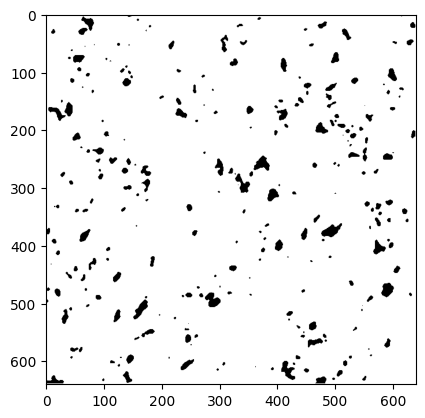

In [125]:
# Check image used in training
fname = train_df.iloc[0,0]
image = Image.open(fname)
plt.imshow(image, cmap='gray')
print("Label:%s\n" % fname)
print("Target:%.4g\n" % train_df.iloc[0,1])

#### Definição do arquitetura do modelo.

Função que cria uma CNN simples com a biblioteca Keras para regressão.

Cria duas camadas intermediárias com uma `camada convolucional 2D` que possui 32 filtros e usa a função de ativação `ReLU`.

O parâmetro `input_shape` define a forma das imagens de entrada para a rede.  

`optimizer='adam'` foi utilizado como otimizador a ser usado durante o treinamento.

`loss='mse'` especifica a função de perda a ser usada durante o treinamento.

In [83]:
# Define architecture model
binary_regressor.build_model()

### Treinamento do modelo

In [84]:
# Load images and train regression model
train_generator, validation_generator = binary_regressor.train()

Found 4746 validated image filenames.
Found 1266 validated image filenames.
Epoch 1/75


 50%|█████     | 75.5M/150M [56:49<55:56, 22.1kB/s]


75/75 [==============================] - 56s 556ms/step - loss: 0.8335 - val_loss: 0.3674
Epoch 2/75
75/75 [==============================] - 39s 516ms/step - loss: 0.2230 - val_loss: 0.1228
Epoch 3/75
75/75 [==============================] - 38s 511ms/step - loss: 0.1132 - val_loss: 0.0931
Epoch 4/75
75/75 [==============================] - 42s 553ms/step - loss: 0.1026 - val_loss: 0.0918
Epoch 5/75
75/75 [==============================] - 39s 518ms/step - loss: 0.1022 - val_loss: 0.0918
Epoch 6/75
75/75 [==============================] - 38s 512ms/step - loss: 0.1022 - val_loss: 0.0918
Epoch 7/75
75/75 [==============================] - 38s 507ms/step - loss: 0.1023 - val_loss: 0.0918
Epoch 8/75
75/75 [==============================] - 39s 513ms/step - loss: 0.1023 - val_loss: 0.0917
Epoch 9/75
75/75 [==============================] - 38s 509ms/step - loss: 0.1023 - val_loss: 0.0918
Epoch 10/75
75/75 [==============================] - 38s 504ms/step - loss: 0.1023 - val_loss: 0.0918


## 6. Avaliação do modelo de deep learning treinado

In [85]:
# Instantiate the evaluation of the model
model_evaluator = EvaluateRegressor(binary_regressor, binary_regressor.model, test_df, binary_regressor.history,input_shape=(640, 640, 1))

In [86]:
# Get metrics to evaluate
y_true,y_pred = model_evaluator.evaluate()

Found 1266 validated image filenames.
1266/1266 [==============================] - 7s 5ms/step
Test Loss: 0.09175758063793182


Testando uma imagem contida no diretório

In [108]:
# Test an image
validation_set = val_df
validation_set.reset_index(drop=True,inplace=True)

unseen_image = validation_set['image_path'][0]
unseen_target = validation_set['target'][0]

# prediction
prediction = model_evaluator.validate(unseen_image).item()
# expected value (model target)
expected = unseen_target
# deviation between the model prediction and the target
deviation = (abs(prediction-expected)/expected)*100

# Print values
print("Expected:", expected)
print("Prediction:", prediction)
print("Dev%:", deviation)

1/1 [==============================] - 0s 21ms/step
Expected: 1.52765
Prediction: 1.2719696760177612
Dev%: 16.7368391962975


#### Visualização das métricas de avaliação do modelo treinado

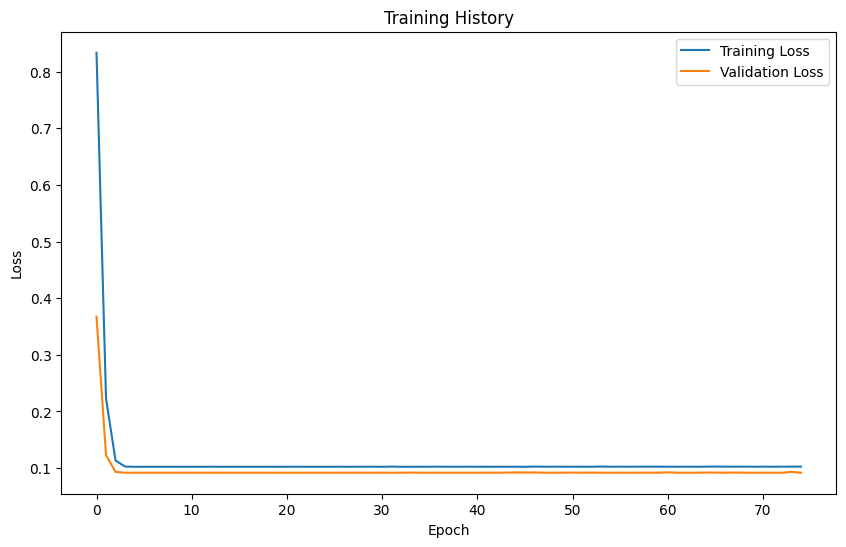

In [109]:
# Plot training history
model_evaluator.plot_training_history()

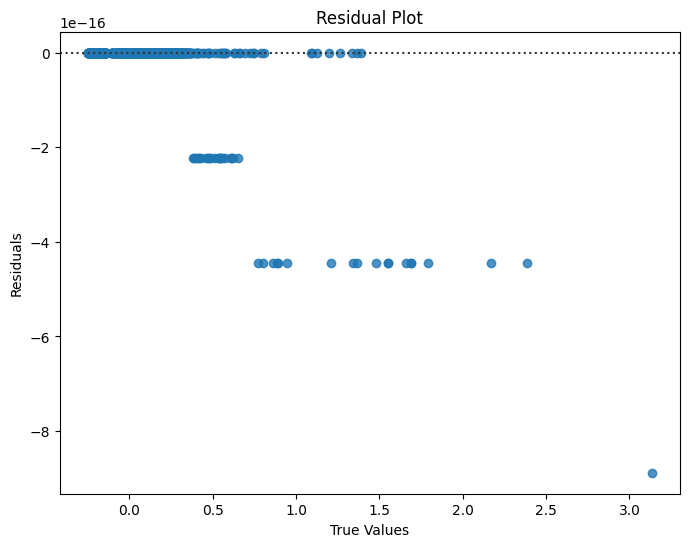

In [110]:
# Plot model residuals using seaborn
model_evaluator.plot_residuals(y_true,y_pred)

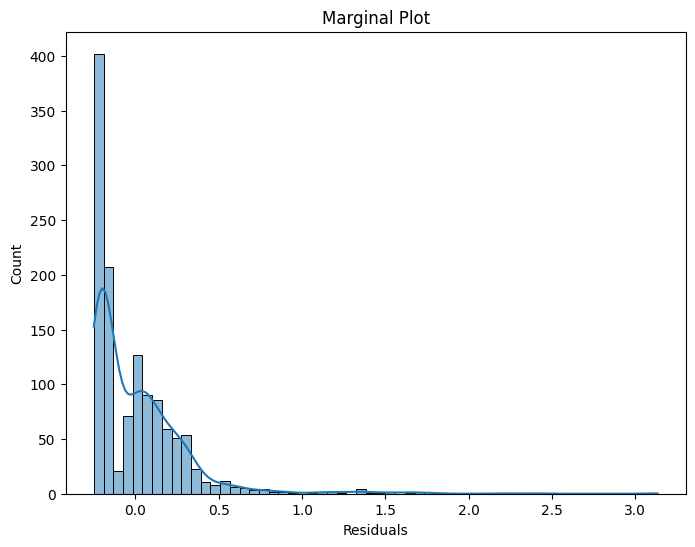

In [111]:
# Marginal plot using seaborn
model_evaluator.plot_marginal(y_true,y_pred)

## 7. Exportação do modelo de deep learning para posterior uso

Salvando o modelo de deep learning que foi treinado

In [112]:
# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

path_model = 'trained_models'

name_model = 'trained_regmodel_' + formatted_datetime + '.h5'

# salvando o modelo
binary_regressor.model.save("%s/%s" % (path_model, name_model))
print("Modelo salvo com o nome: ", name_model)

Modelo salvo com o nome:  trained_regmodel_2023-07-17T1805.h5


## 8. Teste do modelo exportado

Carregando o modelo salvo

In [113]:
#Load trained model
loaded_model = keras.models.load_model("%s/%s" % (path_model, name_model))
print("Modelo %s carregado com sucesso" % (name_model))

Modelo trained_regmodel_2023-07-17T1805.h5 carregado com sucesso


Executando o modelo exportado para acompanhar as classificações de cada uma das imagens de teste

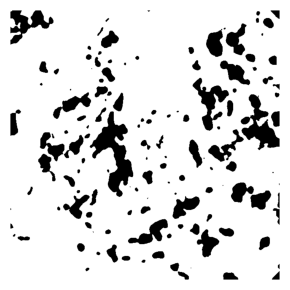

1/1 [==============================] - 0s 24ms/step
1
Label: am8_c2_final-1503.tif
Expected: 1.52765
Prediction: 1.2719696760177612
Dev%: 16.7368391962975




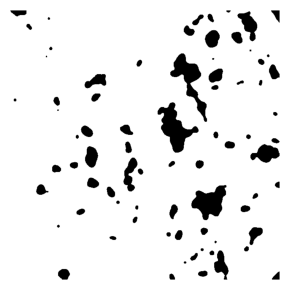

1/1 [==============================] - 0s 27ms/step
2
Label: am8_c1_final-1597.tif
Expected: 1.19877
Prediction: 1.2719696760177612
Dev%: 6.106231889166508




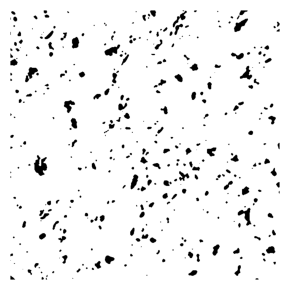

1/1 [==============================] - 0s 27ms/step
3
Label: am5_c1_final-1661.tif
Expected: 1.10147
Prediction: 1.2719696760177612
Dev%: 15.479284594020834




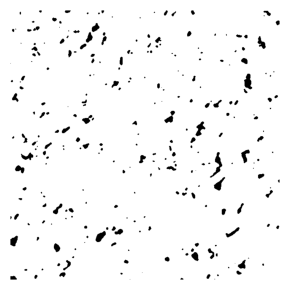

1/1 [==============================] - 0s 23ms/step
4
Label: am5_c1_final-1263.tif
Expected: 1.06426
Prediction: 1.2719696760177612
Dev%: 19.51681694489704




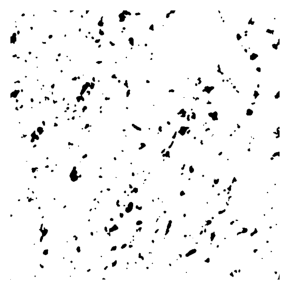

1/1 [==============================] - 0s 25ms/step
5
Label: am5_c2_final-0837.tif
Expected: 1.08119
Prediction: 1.2719696760177612
Dev%: 17.645342263409866




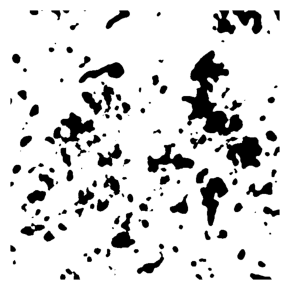

1/1 [==============================] - 0s 19ms/step
6
Label: am8_c2_final-0585.tif
Expected: 1.53133
Prediction: 1.2719696760177612
Dev%: 16.936932208096152




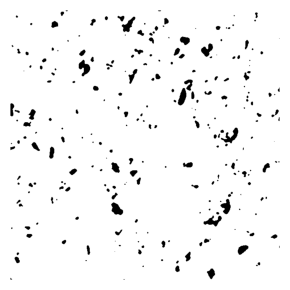

1/1 [==============================] - 0s 27ms/step
7
Label: am5_c1_final-1163.tif
Expected: 1.06983
Prediction: 1.2719696760177612
Dev%: 18.894560445842906




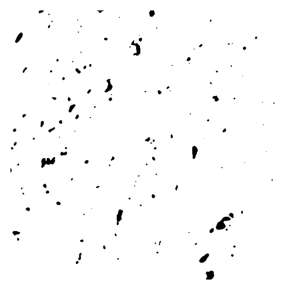

1/1 [==============================] - 0s 32ms/step
8
Label: am5_c1_final-0202.tif
Expected: 1.02703
Prediction: 1.2719696760177612
Dev%: 23.849320469485903




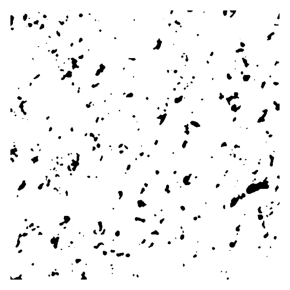

1/1 [==============================] - 0s 27ms/step
9
Label: am5_c1_final-1381.tif
Expected: 1.09852
Prediction: 1.2719696760177612
Dev%: 15.789396280246267




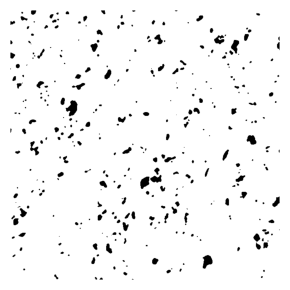

1/1 [==============================] - 0s 23ms/step
10
Label: am5_c2_final-0751.tif
Expected: 1.07197
Prediction: 1.2719696760177612
Dev%: 18.657208319053808




In [126]:
# Unseen image group
df = val_df

#counter
count = 1

# Loop for validation set
for ind in df.index:
    # Showing only 10 images of validation set
    if count < 11:

        # Load image
        img_path = df['image_path'][ind]
        image = Image.open(img_path)
        fig,ax = plt.subplots(figsize = (3,3))
        plt.axis('off')
        ax = plt.imshow(image, cmap='gray')
        plt.tight_layout()
        plt.show()


        # Testing an image
        img = tf.keras.preprocessing.image.load_img(img_path, color_mode="grayscale", target_size=(img_height,img_width))
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = x.astype('float32') / 255.0

        # prediction
        prediction = loaded_model.predict(tf.expand_dims(x, axis=0)).item()

        # expected value (model target)
        expected = df['target'][ind]

        # deviation between the model prediction and the target
        deviation = (abs(prediction-expected)/expected)*100

        # Print values
        print(count)
        print("Label:", img_path)
        print("Expected:", expected)
        print("Prediction:", prediction)
        print("Dev%:", deviation)
        print("\n")
        count += 1

    else:
        # After 10 images stop loop
        break